# Import photos

In [176]:
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, InputLayer
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import nasnet, resnet50, densenet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, fbeta_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import json

%matplotlib inline

In [177]:
base_dir = 'data_3'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training infected Cicada pictures
train_1_dir = os.path.join(train_dir, '1')

# Directory with our training normal Cicada pictures
train_0_dir = os.path.join(train_dir, '0')

# Directory with our validation infected Cicada pictures
validation_1_dir = os.path.join(validation_dir, '1')

# Directory with our validation normal Cicada pictures
validation_0_dir = os.path.join(validation_dir, '0')

# Directory with our test infected Cicada pictures
test_1_dir = os.path.join(test_dir, '1')

# Directory with our test normal Cicada pictures
test_0_dir = os.path.join(test_dir, '0')

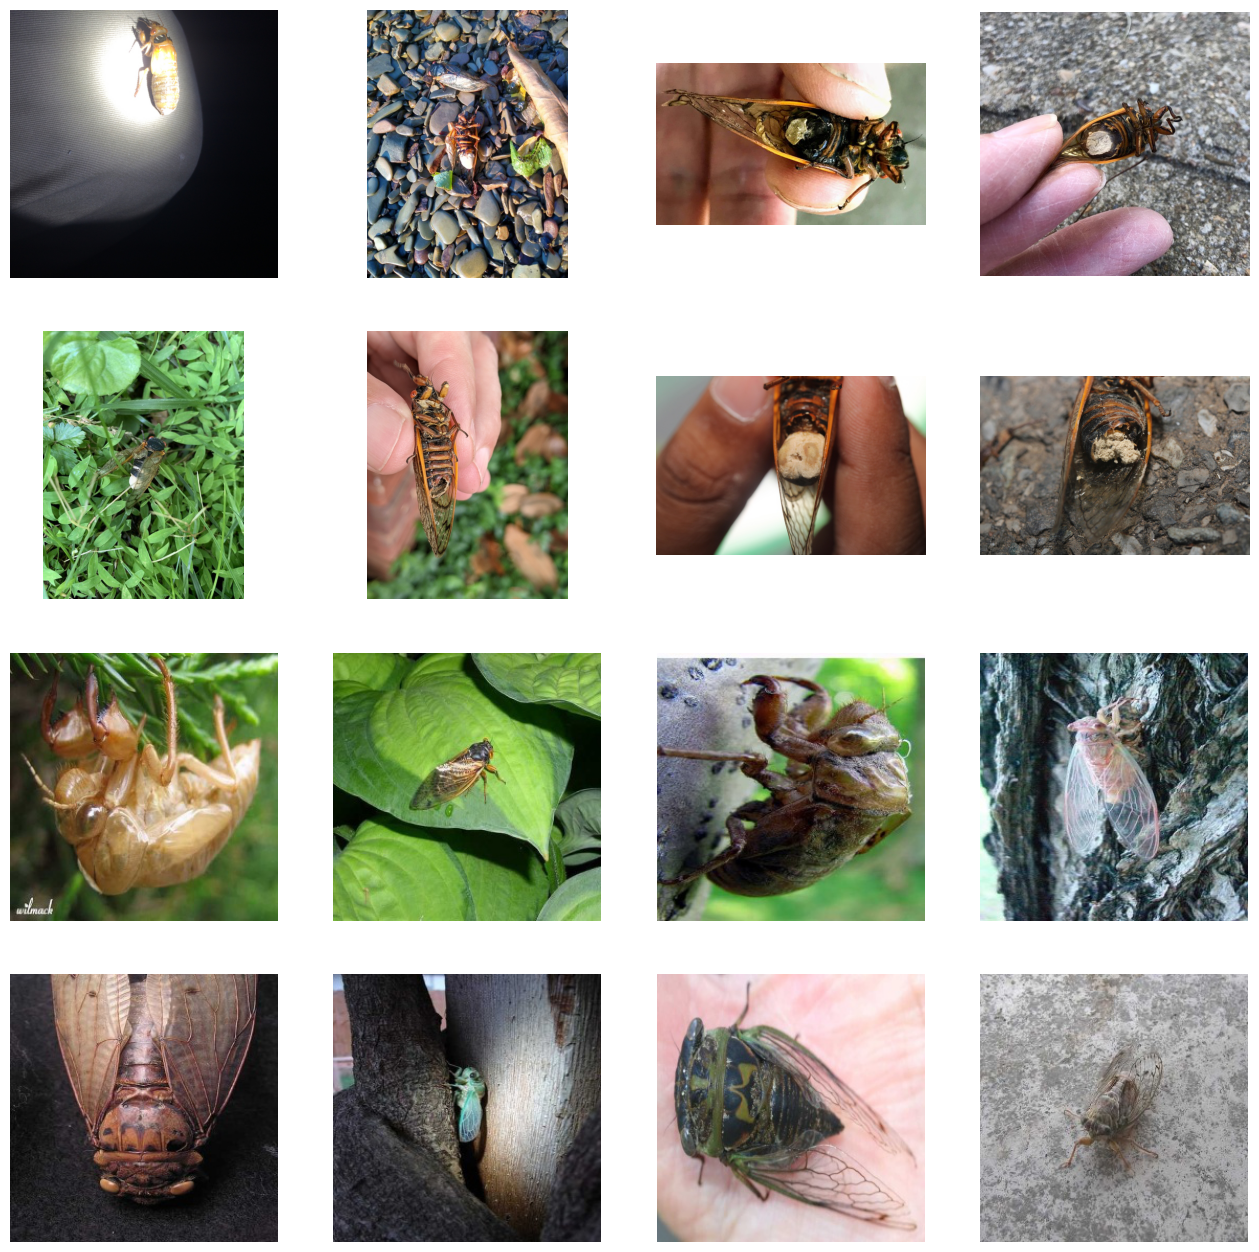

In [178]:
#Set up matplotlib fig, and size it to fit 4x4 pics

import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_1_fnames = os.listdir( train_1_dir )
train_0_fnames = os.listdir( train_0_dir )


next_1_pix = [os.path.join(train_1_dir, fname) 
                for fname in train_1_fnames[ pic_index-8:pic_index] 
               ]

next_0_pix = [os.path.join(train_0_dir, fname) 
                for fname in train_0_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_1_pix+next_0_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# VGG-16 Model (Very Deep Convolutional Networks for Large-Scale Image Recognition)

In [179]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data and test data should not be augmented!

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [180]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

#tried ORIGINAL - but thisnk this is wrong validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))
validation_generator = validation_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))


Found 1000 images belonging to 2 classes.
Found 413 images belonging to 2 classes.


In [181]:
# Flow validation images in batches of 20 using test_datagen generator
test_generator = test_datagen.flow_from_directory( test_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 543 images belonging to 2 classes.


In [182]:
#batch = train_generator.next() 

In [183]:
#batch[0][0]               # this is one 150,150,3 color photo

In [184]:
#batch[1][0]               # this is the one-hot encoded label for this photo

In [185]:
#batch[0][1]               # this is the one-hot encoded label for this photo

In [186]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [187]:
for layer in base_model.layers:
    layer.trainable = False

In [188]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [189]:
#tf.keras.callbacks.EarlyStopping(
 #   monitor='val_loss',
  #  min_delta=0,
# patience=0,
#    verbose=0,
#    mode='auto',
#    baseline=None,
#    restore_best_weights=False,
#    start_from_epoch=0
#)

In [190]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=3)

In [191]:
# ORIGINAL vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)
vgghist = model.fit(train_generator, validation_data = validation_generator,verbose=1, epochs=4)

Epoch 1/4


/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 372s 7s/step - acc: 0.6219 - loss: 0.8369 - val_acc: 0.6174 - val_loss: 0.6911
Epoch 2/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - acc: 0.7511 - loss: 0.5523 - val_acc: 0.6465 - val_loss: 0.7334
Epoch 3/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 340s 7s/step - acc: 0.7703 - loss: 0.4931 - val_acc: 0.7022 - val_loss: 0.6490
Epoch 4/4
50/50 ━━━━━━━━━━━━━━━━━━━━ 1280s 26s/step - acc: 0.8150 - loss: 0.4476 - val_acc: 0.8160 - val_loss: 0.3864


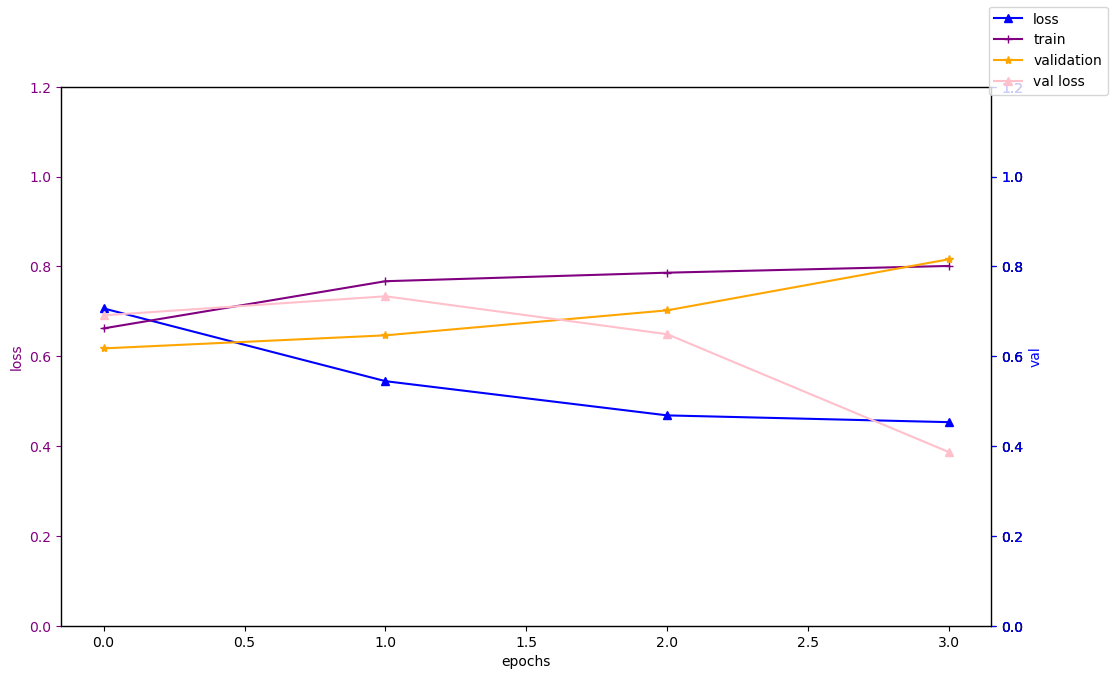

In [192]:
fig, ax1 = plt.subplots(1,1,figsize=(12,7))
ax1.plot(vgghist.epoch, vgghist.history['loss'], marker='^', color='blue', label='loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss', color='purple')
ax1.tick_params('y', colors='purple')
ax1.set_ylim(0,1.2)

ax2 = ax1.twinx()
plt.plot(vgghist.epoch, vgghist.history['acc'], marker='+', color='purple', label='train')
ax2.set_ylabel('val', color='blue')
ax2.set_ylim(0,1.2)

ax3 = ax1.twinx()
plt.plot(vgghist.epoch, vgghist.history['val_acc'], marker='*', color='orange', label='validation')
ax3.set_ylim(0,1.2)

ax4 = ax1.twinx()
ax4.plot(vgghist.epoch, vgghist.history['val_loss'], marker='^', color='pink',label='val loss')
ax4.set_xlabel('epochs')
ax4.tick_params('y', colors='blue')
ax4.set_ylim(0,1.2)


fig.legend();

In [193]:
vgghist_t = vgghist.model.fit(test_generator,verbose=1, epochs=2)

Epoch 1/2
28/28 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - acc: 0.9115 - loss: 0.2080
Epoch 2/2
28/28 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - acc: 0.9722 - loss: 0.1190


In [84]:
yhat = vgghist_t.model.predict(test_generator)

23/23 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step


In [159]:
#from keras.applications.vgg16 import decode_predictions
# convert the probabilities to class labels
#label = decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
#label = label[0][0]
# print the classification
#print('%s (%.2f%%)' % (label[1], label[2]*100))

In [160]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Predict the values from the validation dataset

loss, accuracy = model.evaluate(test_generator)
print('Test: accuracy = %f  ;  loss = %f ' % (accuracy, loss))
y_pred =  vgghist.model.predict(test_generator)
y_p = np.where(y_pred > 0.5, 1,0)
#test_generator=test_datagen.unbatch()
y_g=[]
for image, label in  test_generator:
  y_g.append(label.numpy())

confusion_mtx = confusion_matrix(y_g, y_p) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap='Blues',linecolor='gray', fmt= '.1f',ax=ax)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 140s 5s/step - acc: 0.9708 - loss: 0.0681
Test: accuracy = 0.977901  ;  loss = 0.058707 
28/28 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_54107/1249956868.py", line 13, in <module>
    y_g.append(label.numpy())
               ^^^^^^^^^^^
AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1326, 

In [ ]:
history = vgghist

In [194]:
#1.Predict classes
import sklearn
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = vgghist.model.predict(test_generator)

# Get most likely class
predicted_classes = [1 * (x[0]>=0.5) for x in predictions]

# 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 

# 3. Use scikit-learn to get statistics
from sklearn.metrics import confusion_matrix,classification_report,f1_score, fbeta_score

print(class_labels)

print(confusion_matrix(test_generator.classes, predicted_classes))
print(fbeta_score)
report = sklearn.metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

28/28 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step
['0', '1']
[[460  36]
 [ 46   1]]
<function fbeta_score at 0x14c8514e0>
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       496
           1       0.03      0.02      0.02        47

    accuracy                           0.85       543
   macro avg       0.47      0.47      0.47       543
weighted avg       0.83      0.85      0.84       543



In [195]:
print(class_labels, true_classes, predicted_classes)


['0', '1'] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0

In [204]:
true_classes = true_classes.tolist()

In [205]:
print(true_classes)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [206]:
print(class_labels, true_classes, predicted_classes)

['0', '1'] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [207]:
## Calculate the confusion matrix here

TN = confusion_matrix(true_classes, predicted_classes)[0,0]
FP = confusion_matrix(true_classes, predicted_classes)[0,1]
FN = confusion_matrix(true_classes, predicted_classes)[1,0]
TP = confusion_matrix(true_classes, predicted_classes)[1,1]

print('TN: ', TN)
print('FP: ', FP)
print('FN: ', FN)
print('TP: ', TP)

TN:  460
FP:  36
FN:  46
TP:  1


In [ ]:
img

In [208]:
pd.DataFrame({'image_id' : [img],
                                'true_classes' : [true_classes],
                                'predicted_classes' : [predicted_classes] }, 
                                columns=['image_id','true_classes', 'predicted_classes'])

,image_id,true_classes,predicted_classes
0,"[[[162, 162, 164], [179, 179, 181], [198, 198,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [210]:
img = np.array(img)
predicted_classes = np.array(predicted_classes)
true_classes = np.array(true_classes)

In [212]:
df = pd.DataFrame({'image_id' : [img],
                                'true_classes' : [true_classes],
                                'predicted_classes' : [predicted_classes] }, 
                                columns=['image_id','true_classes', 'predicted_classes'])

In [213]:
df

,image_id,true_classes,predicted_classes
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [196]:
cf_matrix = confusion_matrix(predicted_classes, true_classes)

In [215]:
import seaborn as sns
labels = ['True Neg','False Pos','False Neg','True Pos']
category = ['Zero', 'One']
sns.heatmap.confusion_matrix(cf_matrix, 
            labels = labels,
            category = category,
            cmap ='binary',
            annot=True, 
            fmt='g')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_54107/1028062491.py", line 4, in <module>
    sns.heatmap.confusion_matrix(cf_matrix,
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'function' object has no attribute 'confusion_matrix'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core

<Axes: >

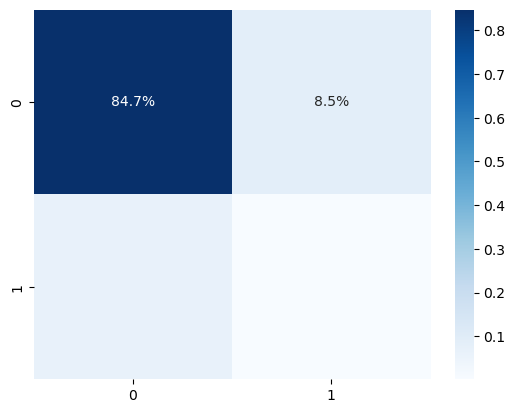

In [214]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.1%', cmap='Blues')

<Axes: >

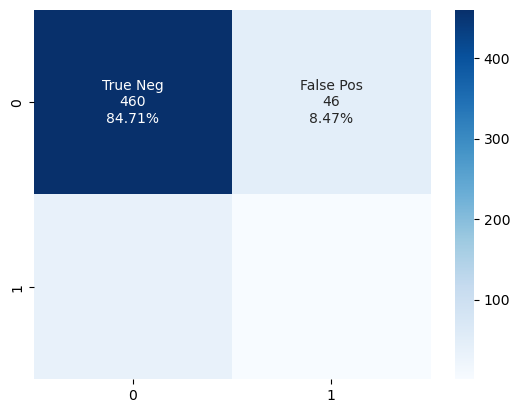

In [199]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [153]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
confusion_matrix(cf_matrix, 
                      group_names= labels,
                      categories=categories, 
                      cmap='binary')

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_54107/3269513140.py", line 3, in <module>
    confusion_matrix(cf_matrix,
TypeError: confusion_matrix() got an unexpected keyword argument 'group_names'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1326, in structur

In [131]:
print((true_classes), print(predicted_classes))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 

In [123]:

predicted_classes = np.array(predicted_classes)


In [124]:
print(predicted_classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 

In [130]:
true_c = true_classes
pred_c = predicted_classes

arr = np.concatenate((true_c, pred_c), axis=1)


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_54107/2582608516.py", line 4, in <module>
    arr = np.concatenate((true_c, pred_c), axis=1)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
numpy.exceptions.AxisError: axis 1 is out of bounds for array of dimension 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/pytho

In [129]:
print(arr)

[0 0 0 ... 0 0 0]


In [43]:
from sklearn.metrics import fbeta_score, make_scorer


ftwo_scorer = make_scorer(fbeta_score, beta=2, average='weighted')

In [44]:
tf.keras.metrics.FBetaScore(
    average=None,
    beta=1.0,
    threshold=None,
    name='fbeta_score',
    dtype=None
)

<FBetaScore name=fbeta_score>

In [45]:
b2 = beta ** 2
f_beta_score = (1 + b2) * (precision * recall) / (precision * b2 + recall)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_54107/3161776868.py", line 1, in <module>
    b2 = beta ** 2
         ^^^^
NameError: name 'beta' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1326, in structured_traceback
    return VerboseTB.struct

In [46]:
## calculate recall and precision here
print("The training recall is",
         np.round(TP/(TP+FN),4))

print("The training precision is",
         np.round(TP/(TP+FP),4))


The training recall is 0.2941
The training precision is 0.2941


## F-Beta score = (1 + Beta²) * ((precision * recall) / (Beta² * precision + recall))

In [57]:

from sklearn.metrics import fbeta_score

y_true = true_classes
y_pred = predicted_classes
beta = 0.5

f_beta = fbeta_score(y_true, y_pred, beta=beta)

print("f-Beta Score: ", f_beta)


f-Beta Score:  0.0


In [42]:
print(class_labels)

['0', '1']


In [43]:
print(confusion_matrix(test_generator.classes, predicted_classes))

[[474  22]
 [ 47   0]]


In [47]:
print("Precision: %s, Recall: %s, F-beta score: %s" %(prec, recall, fbeta))

NameError: name 'prec' is not defined

In [39]:
print(predictions)

[[2.89754735e-06]
 [8.51221383e-02]
 [9.62394536e-01]
 [5.23707073e-04]
 [8.31117086e-06]
 [1.81268551e-03]
 [5.24441595e-04]
 [2.13557229e-04]
 [1.68558399e-04]
 [1.41668052e-03]
 [1.36559229e-05]
 [1.41366327e-04]
 [5.29401659e-05]
 [1.05678407e-03]
 [6.52630522e-04]
 [6.43998210e-04]
 [1.09001191e-03]
 [3.17715737e-03]
 [1.77554059e-04]
 [2.21373339e-04]
 [7.41029435e-05]
 [7.61049858e-04]
 [9.78275086e-04]
 [2.58747092e-03]
 [2.29588375e-04]
 [2.51950463e-03]
 [3.02185444e-03]
 [3.08859814e-03]
 [2.30361926e-04]
 [3.85276275e-04]
 [1.84721812e-05]
 [7.98978435e-05]
 [9.08910937e-04]
 [5.66357558e-05]
 [9.37753066e-06]
 [2.55245377e-05]
 [8.04596813e-04]
 [1.21988807e-04]
 [5.42451162e-04]
 [1.44202248e-04]
 [1.06272649e-03]
 [4.88989860e-01]
 [5.49111064e-05]
 [4.26183178e-05]
 [6.97566111e-06]
 [7.42290344e-04]
 [5.30705256e-05]
 [7.98344961e-04]
 [1.53775408e-03]
 [1.26611412e-04]
 [2.05619450e-04]
 [2.89294345e-04]
 [9.82950558e-04]
 [7.10499517e-05]
 [2.31572252e-04]
 [2.742341

In [24]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [25]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42

from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage
# from fastai.vision.learner import *
# from fastai import *
from fastai.basics import *
from cv2 import resize
import matplotlib.gridspec as gridspec
from math import ceil
from IPython.display import HTML
from pdb import set_trace
import torchvision.models as models
from torchvision import *
from torch import *
# from scipy import ndimage

import gc
import cv2
import matplotlib.gridspec as gridspec
import time
np.random.seed(seed)


ModuleNotFoundError: No module named 'fastai.callbacks'

In [26]:
class SaveFeatures():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output
    def close(self):
        self.hook.remove()

def np2tensor(image,dtype):
    "Convert np.array (sz,sz,3) to tensor (1,3,sz,sz), imagenet normalized"

    a = np.asarray(image)
    if a.ndim==2 : a = np.expand_dims(a,2)
    a = np.transpose(a, (1, 0, 2))
    a = np.transpose(a, (2, 1, 0))
    
    #Imagenet norm
    mean=np.array([0.485, 0.456, 0.406])[...,np.newaxis,np.newaxis]
    std = np.array([0.229, 0.224, 0.225])[...,np.newaxis,np.newaxis]
    a = (a-mean)/std
    a = np.expand_dims(a,0)
    return torch.from_numpy(a.astype(dtype, copy=False) )

def tensor2np(img_tensor):
    "Convert tensor (1,3,sz,sz) back to np.array (sz,sz,3), imagenet DEnormalized"
    a = np.squeeze(to_np(img_tensor))
    mean=np.array([0.485, 0.456, 0.406])[...,np.newaxis,np.newaxis]
    std = np.array([0.229, 0.224, 0.225])[...,np.newaxis,np.newaxis]
    a = a*std + mean
    return np.transpose(a, (1,2,0))

class FilterVisualizer():
    def __init__(self,model):
        self.model = model

    def visualize(self, sz, layer, filter, upscaling_steps=12, upscaling_factor=1.2, lr=0.01, opt_steps=50, blur=5, print_losses=False):
        
        img = (np.random.random((sz,sz, 3)) * 20 + 128.)/255 # value b/t 0 and 1        
        activations = SaveFeatures(layer)  # register hook
        torch.cuda.empty_cache()
        for i in range(upscaling_steps):  
            # convert np to tensor + channel first + new axis, and apply imagenet norm
            img_tensor = np2tensor(img,np.float32)
            img_tensor = img_tensor.cuda()
            img_tensor.requires_grad_();
            if not img_tensor.grad is None:
                img_tensor.grad.zero_(); 

            optimizer = torch.optim.Adam([img_tensor], lr=lr, weight_decay=1e-6)
            if i > upscaling_steps/2:
                opt_steps_ = int(opt_steps*1.3)
            else:
                opt_steps_ = opt_steps
            for n in range(opt_steps_):  # optimize pixel values for opt_steps times
                optimizer.zero_grad()
                _=self.model(img_tensor)
                loss = -1*activations.features[0, filter].mean()
                if print_losses:
                    if i%3==0 and n%5==0:
                        # print(f'{i} - {n} - {float(loss)}')
                        if loss == 0:
                            break
                loss.backward()
                optimizer.step()
            
            # convert tensor back to np
            img = tensor2np(img_tensor)
            self.output = img
            sz = int(upscaling_factor * sz)  # calculate new image size
            # print(f'Upscale img to: {sz}')
            img = cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)  # scale image up
            if blur is not None: img = cv2.blur(img,(blur,blur))  # blur image to reduce high frequency patterns
        activations.close()
        return np.clip(self.output, 0, 1)
    
    def get_transformed_img(self,img,sz):
        '''
        Scale up/down img to sz. Channel last (same as input)
        image: np.array [sz,sz,3], already divided by 255"    
        '''
        return cv2.resize(img, (sz, sz), interpolation = cv2.INTER_CUBIC)
    
    def most_activated(self, img, layer):
        '''
        image: np.array [sz,sz,3], already divided by 255"    
        '''
        img = cv2.resize(img, (224,224), interpolation = cv2.INTER_CUBIC)
        activations = SaveFeatures(layer)
        img_tensor = np2tensor(img,np.float32)
        img_tensor = img_tensor.cuda()
        
        _=self.model(img_tensor)
        mean_act = [np.squeeze(to_np(activations.features[0,i].mean())) for i in range(activations.features.shape[1])]
        activations.close()
        return mean_act                

## Plot the Image

In [27]:
def plot_activations_and_reconstructions(imgs,activations,filters,
                                         transformed_img,n_cols=3,
                                         cell_size=4,layer_name='',
                                         save_fig=False,album_hash=None):
    n_rows = math.ceil((len(imgs)+1)/n_cols)

    fig = plt.figure(figsize=(cell_size*n_cols,cell_size*n_rows))
    gs = gridspec.GridSpec(n_rows, n_cols)
    tr_im_ax = plt.subplot(gs[0,0])
    tr_im_ax.grid(False)
    tr_im_ax.get_xaxis().set_visible(False)
    tr_im_ax.get_yaxis().set_visible(False)
    tr_im_ax.imshow(transformed_img)
    tr_im_ax.set_title('Image')
    
    act_ax = plt.subplot(gs[0, 1:])
    
    
    act = act_ax.plot(np.clip(activations,0.,None),linewidth=2.)
    for el in filters:
        act_ax.axvline(x=el, color='red', linestyle='--',alpha=0.4)
    act_ax.set_xlim(0,len(activations));
    act_ax.set_ylabel(f"mean activation");
    if layer_name == '':
        act_ax.set_title('Mean Activations')
    else:
        act_ax.set_title(f'{layer_name}')
    act_ax.set_facecolor('white')
    
    fmap_axes = []
    for r in range(1,n_rows):
        for c in range(n_cols):
            fmap_axes.append(plt.subplot(gs[r, c]))
            
    for i,ax in enumerate(fmap_axes):
        ax.grid(False)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i>=len(filters):
            pass

        ax.set_title(f'fmap {filters[i]}')

        ax.imshow(imgs[i])
    plt.tight_layout()
    save_name = layer_name.lower().replace(' ','_')
    plt.show()  

In [28]:
def activations_and_reconstructions(img,fmap_layer,
                                    top_num=4,init_size=56,
                                    upscaling_steps=12, upscaling_factor=1.2,
                                    opt_steps=75, blur=5,lr=0.01,
                                    print_losses=False,
                                    n_cols=3, cell_size=4,
                                    layer_name='',
                                    save_fig=False,
                                    album_hash=None):
    
    mean_acts = FV.most_activated(img,layer = fmap_layer)

    most_act_fmaps = sorted(range(len(mean_acts)), key=lambda i: mean_acts[i])[-top_num:][::-1]

    imgs = []
    for filter in most_act_fmaps:
        imgs.append(FV.visualize(init_size,fmap_layer, filter, upscaling_steps=upscaling_steps, 
                                 upscaling_factor=upscaling_factor, 
                                 opt_steps=opt_steps, blur=blur,
                                 lr=lr,print_losses=False))
    transformed_img = FV.get_transformed_img(img,224)
    
    plot_activations_and_reconstructions(imgs,mean_acts,
                                         most_act_fmaps,transformed_img,
                                         n_cols=n_cols,cell_size=cell_size,
                                         layer_name=layer_name,
                                         save_fig=save_fig,
                                         album_hash=album_hash)

## Visualize feature map with highest mean activation for an input

In [35]:
#m = models.vgghist(True).cuda().eval()
#m = vgghist.modelVGG19(True).cuda().eval()
#m = vgghist.vgg19(True).cuda().eval()
m = VGG16.vgghist(True).cuda().eval()

AttributeError: 'function' object has no attribute 'vgghist'

In [99]:
FV = FilterVisualizer(m)

NameError: name 'm' is not defined

In [9]:
image_file_path = "data/test/1/comphotos133493190medium.jpeg"
im = np.array(PIL.Image.open(image_file_path).convert('RGB')).astype(np.float32)/255
plt.imshow(im)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_20924/1828434360.py", line 2, in <module>
    im = np.array(PIL.Image.open(image_file_path).convert('RGB')).astype(np.float32)/255
         ^^
NameError: name 'np' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2144, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/IPython/core/ultratb.p